In [1]:
# Import usefull package including TorchClassifierData
from TorchClassifierData import ClassifierImporter,ClassifierDisplayer
from TorchClassifierData import ClassifierTrainTestSpliter,ClassifierNormalizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:

torch.cuda.is_available()

True

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# Download kaggle dataset and import the path
# https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition
datapath=r"C:\Users\charleslf\Downloads\Compressed\Dataset"

In [5]:
# Import the dataset with ClassifierImporter 
# with size (WIDTH=50,HEIGHT=50)
classes=["Bus","Car","motorcycle","Truck"]
vehi_dataset=ClassifierImporter(datapath,classes,size=(50,50))

In [6]:
# Create a trainset and a testset with ClassifierTrainTestSpliter
trainset,testset=ClassifierTrainTestSpliter(vehi_dataset,test_size=0.2)

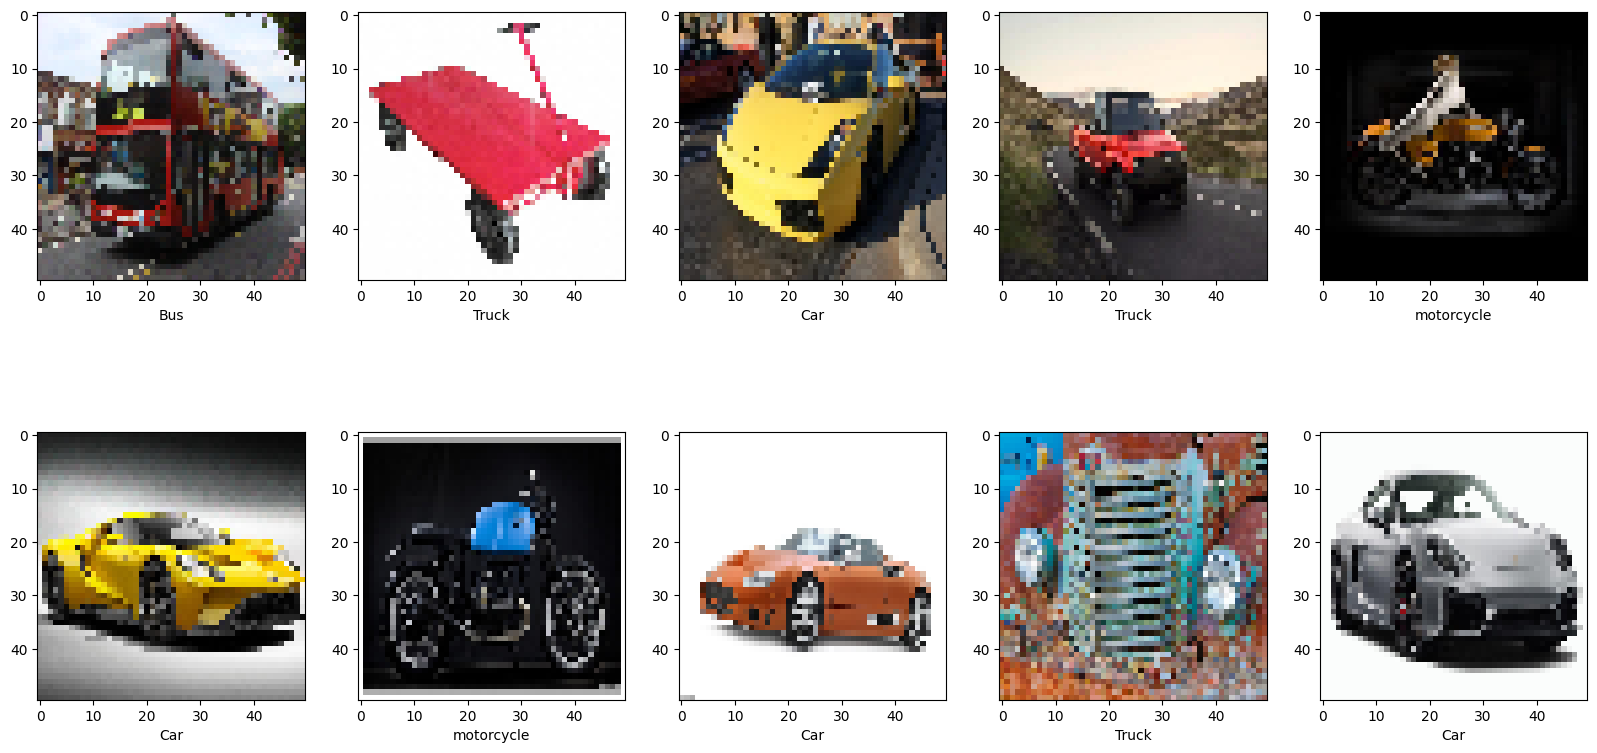

In [7]:
# Display the trainset with ClassifierDisplayer
ClassifierDisplayer(trainset,classes,batch=2)

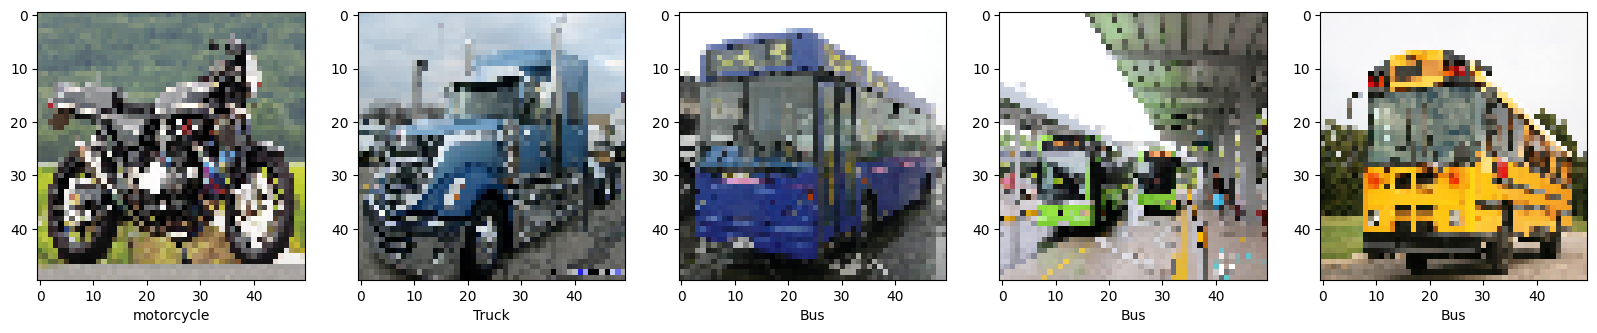

In [8]:
# Display the testset with ClassifierDisplayer
ClassifierDisplayer(testset,classes,batch=1)

In [9]:
# Normalize the trainset and testset 
norm_trainset=ClassifierNormalizer(trainset)
norm_testset=ClassifierNormalizer(testset)

In [12]:
# Create trainloader and testloader
batch_size=4
trainloader=DataLoader(norm_trainset,batch_size=batch_size,num_workers=2)
testloader=DataLoader(norm_testset,batch_size=batch_size,num_workers=2)

In [13]:
# Create a simple model 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(1296,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()
print(net)
net.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
# Train the model for 100 epochs
for epoch in range(50):
    print("Epoch {} \n ----------------".format(epoch))
    for i,data in enumerate(trainloader,0):
        inputs,labels=data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10==0:
            print("loss:{}".format(loss.item()))
print("Finished Trainning")

Epoch 0 
 ----------------
loss:2.3750839233398438
loss:2.401491641998291
loss:2.352142810821533
loss:2.4280288219451904
loss:2.3364012241363525
loss:2.3143234252929688
loss:2.350477457046509
loss:2.3511760234832764
Epoch 1 
 ----------------
loss:2.358746290206909
loss:2.3863353729248047
loss:2.3354599475860596
loss:2.410619020462036
loss:2.3174514770507812
loss:2.297001838684082
loss:2.332852840423584
loss:2.333691358566284
Epoch 2 
 ----------------
loss:2.3406002521514893
loss:2.370845317840576
loss:2.3191161155700684
loss:2.39367938041687
loss:2.298861503601074
loss:2.2800559997558594
loss:2.3156940937042236
loss:2.316699266433716
Epoch 3 
 ----------------
loss:2.322866439819336
loss:2.3556509017944336
loss:2.3030009269714355
loss:2.377291202545166
loss:2.280576229095459
loss:2.2633326053619385
loss:2.2989087104797363
loss:2.3002965450286865
Epoch 4 
 ----------------
loss:2.305657386779785
loss:2.3406808376312256
loss:2.2871956825256348
loss:2.3612356185913086
loss:2.26293277740

In [88]:
# TEST

In [16]:
# print the total accuracy
# need more data and training epochs obviously
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data[0].to(device),data[1].to(device)
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print("Accuracy on 80 test images",100*correct//total,"%")

Accuracy on 80 test images 28 %


In [18]:
# print the predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Bus   is 0.0 %
Accuracy for class: Car   is 18.2 %
Accuracy for class: motorcycle is 0.0 %
Accuracy for class: Truck is 95.5 %
